In [3]:
library(reshape2)
library(tidyr)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(qs)
library(data.table)
library(ggthemes)
library(stringr)
library(Seurat)
library(anndata)

Warning message:
“package ‘reshape2’ was built under R version 4.2.1”

Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


qs 0.25.5

Warning message:
“package ‘data.table’ was built under R version 4.2.2”

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following objects are masked from ‘package:reshape2’:

    dcast, melt


Warning message:
“package ‘Seurat’ was built under R version 4.2.2”
Attaching SeuratObject



In [4]:
packageVersion('ggplot2')

[1] ‘3.4.4’

In [26]:
setwd('/home/mingjian/workbase/04_chemical.methods/07.code_submit/data/')

# Fig2A

In [24]:
all_data_rate <- fread('Fig2A_data.csv')

Warning message in fread("/home/mingjian/workbase/04_chemical.methods/07.code_submit/data/Fig2A_data.csv"):
“Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call.”


In [25]:
head(all_data_rate,2)

variable,value,batch,sample,IQR,Med
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
AC,0.0004256321,1,Ctrl,0.0002487477,0.0005935854
AC,0.0005008186,1,Ctrl,0.0002487477,0.0005935854


In [12]:
rate_order <- c('Ctrl','in-situ-IAA','IAA','mCPBA+TFEA-pH5.2','mCPBA+TFEA-pH7.4','NaIO4+TFEA-pH5.2','NaIO4+TFEA-pH7.4','NaIO4+NH4Cl-pH8.8')
base_order <- c('GT','GC','GA','CT','CG','CA','TC','TG','TA','AT','AG','AC')
all_data_rate$variable <- factor(all_data_rate$variable,levels = base_order)
all_data_rate$sample <- factor(all_data_rate$sample,levels = rate_order)

In [15]:
my.col<-colorRampPalette(brewer.pal(9,'Set1'))(11)
my.col.3<-colorRampPalette(brewer.pal(9,'Set1'))(9)
my.col.3[6] <- '#A6CEE3'

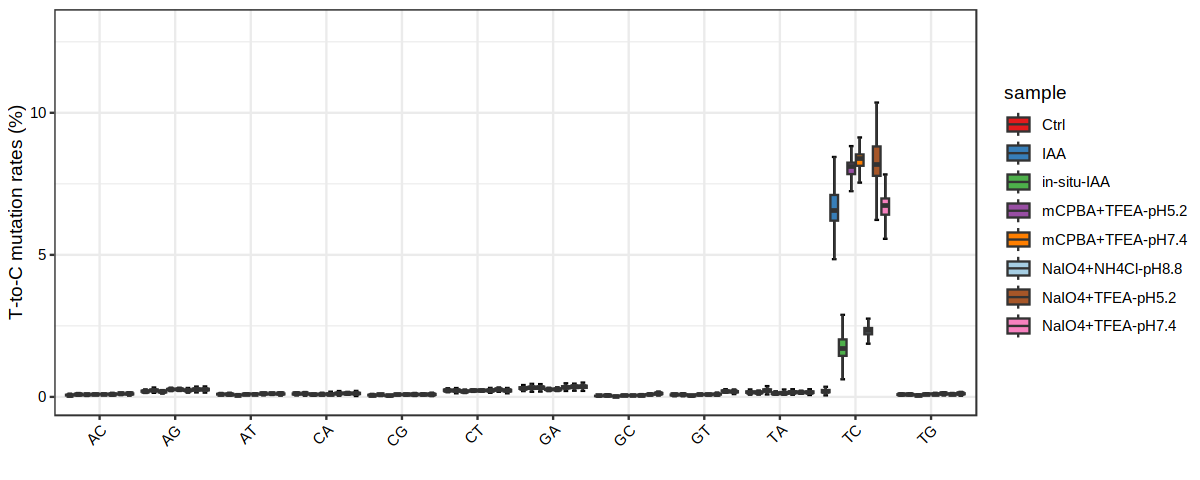

In [27]:
options(repr.plot.height=4,repr.plot.width=10)
ggplot(all_data_rate, aes(variable, value*100, fill = sample)) +
  stat_boxplot(geom = "errorbar",width = 0.5,colour='black',position = position_dodge(0.9)) + 
  geom_boxplot(width = 0.9,outlier.shape = NA) +
  ylab("T-to-C mutation rates (%)") +
  xlab(" ") +
  scale_fill_manual(values = my.col.3) +
  scale_colour_manual(values = my.col.3)+
  coord_cartesian(ylim = c(0,13))+
  theme_bw()+
    theme(
        axis.text.x = element_text(colour = 'black',angle = 45, hjust = 1),  # 设置X轴文本字体为加粗的Arial
        axis.text.y = element_text(colour = 'black')  # 设置Y轴文本字体为加粗的Arial
    )

# Fig2B

In [6]:
new_rna_dat <- fread('Fig2B.csv')

In [38]:
head(new_rna_dat,2)

sample,batch,barcode,nCount_RNA_total,nCount_RNA_label,new_rate
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
IAA,1,AAAAAAGCGGGA,1630,516.9916,31.71727
IAA,1,AAAACGGCGGTG,3123,880.0226,28.17876


In [10]:
label_rate <- new_rna_dat %>% group_by(sample) %>% summarise(mean_rate = round(mean(new_rate),2))

In [11]:
label_rate

sample,mean_rate
<chr>,<dbl>
IAA,36.87
NaIO4+NH4Cl-pH8.8,33.99
NaIO4+TFEA-pH5.2,45.32
NaIO4+TFEA-pH7.4,40.67
in-situ-IAA,18.98
mCPBA+TFEA-pH5.2,41.24
mCPBA+TFEA-pH7.4,43.81


In [13]:
new_rna_dat$sample <- factor(new_rna_dat$sample,levels = rate_order)
label_rate$sample <- factor(label_rate$sample,levels = rate_order)

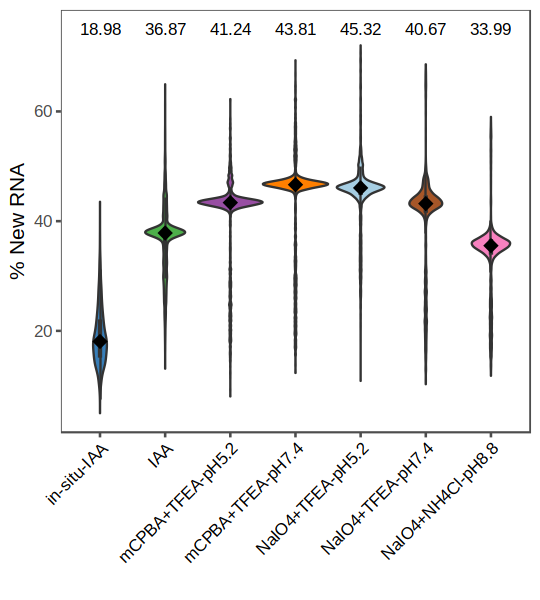

In [17]:
options(repr.plot.height =5, repr.plot.width = 4.5)
ggplot(data = new_rna_dat,mapping = aes(x=sample,y=new_rate,fill=sample))+
  geom_violin(width=1,trim = TRUE)+
  geom_boxplot(width = 0.03,fill='white',outlier.shape = NA) +
  stat_summary(fun.y="median",geom="point",shape=18, size=4,fill="black")+
  ylab("% New RNA") +
  xlab(" ") +
  scale_fill_manual(values = my.col.3[2:8])+
  scale_colour_manual(values = my.col.3[2:8])+
theme_bw()+theme_few()+
  theme(axis.text.x = element_text(colour = 'black',angle = 45, hjust = 1),
                                  legend.position = 'none')+
  geom_text(data = label_rate,mapping = aes(sample,y=75,label=mean_rate),size=3.5)

# Fig2C,Fig2D

In [49]:
saveRDS(pre_dat[,-5],'Fig2CD_data.rds')

In [51]:
pre_dat <- readRDS('Fig2CD_data.rds')

In [52]:
pre_dat$sample <- factor(pre_dat$sample,levels = rate_order)

In [53]:
library(foreach)
library(future.apply)
library(doParallel)
registerDoParallel(cores=10)
plan(multisession, workers = 5)
options(future.globals.maxSize = 2 * 1024^3) 

Warning message:
“package ‘future.apply’ was built under R version 4.2.2”
Loading required package: future

Loading required package: iterators

Loading required package: parallel



In [54]:
predict.nGene <- future_sapply(rate_order, function(u) {
  model1 <- loess(data = subset(pre_dat,nGene >100 & nGene <5000& reads<30000 ) %>%
                    dplyr::filter(sample == u), formula = nGene ~ reads)
  tmp <- predict(model1, 10000)
  return(round(as.numeric(tmp), 0))
})
predict.nGene

Ctrl       in-situ-IAA               IAA  mCPBA+TFEA-pH5.2 
             2353               913              2137              2044 
 mCPBA+TFEA-pH7.4  NaIO4+TFEA-pH5.2  NaIO4+TFEA-pH7.4 NaIO4+NH4Cl-pH8.8 
             1747              2033              1838              2046

In [55]:
df.extra <- data.frame(reads=rep(10000,8),nGene=predict.nGene)
df.extra$orig.ident <- rownames(df.extra)
df.extra

,reads,nGene,orig.ident
,<dbl>,<dbl>,<chr>
Ctrl,10000,2353,Ctrl
in-situ-IAA,10000,913,in-situ-IAA
IAA,10000,2137,IAA
mCPBA+TFEA-pH5.2,10000,2044,mCPBA+TFEA-pH5.2
mCPBA+TFEA-pH7.4,10000,1747,mCPBA+TFEA-pH7.4
NaIO4+TFEA-pH5.2,10000,2033,NaIO4+TFEA-pH5.2
NaIO4+TFEA-pH7.4,10000,1838,NaIO4+TFEA-pH7.4
NaIO4+NH4Cl-pH8.8,10000,2046,NaIO4+NH4Cl-pH8.8


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


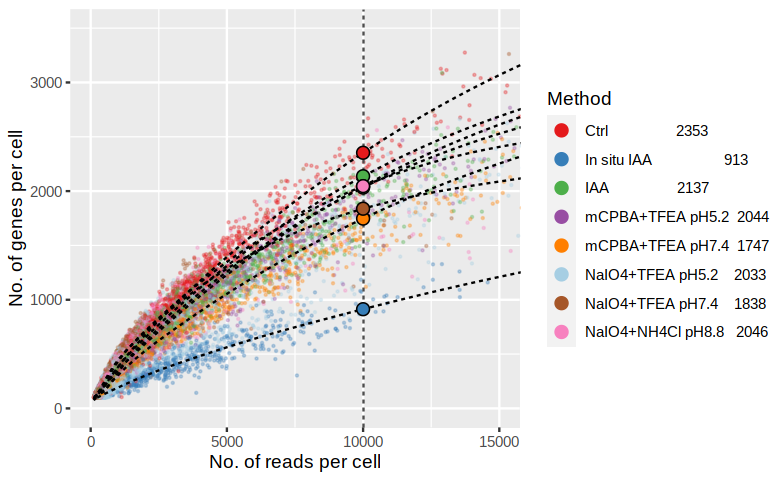

In [57]:
options(repr.plot.width=6.5,repr.plot.height=4)
ggplot(subset(pre_dat,nGene >100 & nGene <5000& reads<30000 ),aes(reads,nGene,col=sample)) + 
  geom_point(data=sample_frac(subset(pre_dat,nGene >100 & nGene <5000& reads<30000 ), 0.2),
             size=.2,shape=19,alpha=.3) + 
  geom_smooth(method="loess",se=F,size=.5,linetype=2,aes(group=sample),col="black") +
  scale_color_manual("Method",values=my.col.3[1:8],labels=c('Ctrl                 2353',
                                                      'In situ IAA                  913',
                                                      'IAA                 2137',
                                                      'mCPBA+TFEA pH5.2  2044',
                                                      'mCPBA+TFEA pH7.4  1747',
                                                      'NaIO4+TFEA pH5.2    2033',
                                                      'NaIO4+TFEA pH7.4    1838',
                                                      'NaIO4+NH4Cl pH8.8   2046'
)) +
  scale_x_continuous(breaks=seq(0,30000,5000),labels=seq(0,30000,5000)) + 
  coord_cartesian(xlim = c(0,15000),ylim = c(0,3500)) + 
  ylab('No. of genes per cell')+
  xlab('No. of reads per cell')+
  geom_vline(xintercept = 10000,col="grey30",linetype="dashed") + 
  geom_point(data = df.extra, fill = my.col.3[1:8],col = 'black',shape = 21,size=3) +
  guides(colour = guide_legend(ncol=1,override.aes=list(size=3,alpha=1)))

In [59]:
predict.nUMI<- future_sapply(rate_order, function(u) {
    model1 <-  stats::lm(data = subset(pre_dat,nUMI >400 & reads <30000) %>% 
                         dplyr::filter(sample == u),formula = nUMI ~ reads)
    tmp <- predict(model1,list(reads=seq(10000,20000,5000)))
    return(round(as.numeric(tmp),0))
})
predict.nUMI

Ctrl,in-situ-IAA,IAA,mCPBA+TFEA-pH5.2,mCPBA+TFEA-pH7.4,NaIO4+TFEA-pH5.2,NaIO4+TFEA-pH7.4,NaIO4+NH4Cl-pH8.8
6260,4723,5362,5468,4350,4365,5310,4973
9349,6989,7997,8161,6449,6433,7840,7300
12439,9255,10631,10854,8547,8501,10371,9628


In [60]:
df.extra2 <- data.frame(reads=rep(10000,8),nUMI=predict.nUMI[1,])
df.extra2$orig.ident <- rownames(df.extra2)
df.extra2

,reads,nUMI,orig.ident
,<dbl>,<dbl>,<chr>
Ctrl,10000,6260,Ctrl
in-situ-IAA,10000,4723,in-situ-IAA
IAA,10000,5362,IAA
mCPBA+TFEA-pH5.2,10000,5468,mCPBA+TFEA-pH5.2
mCPBA+TFEA-pH7.4,10000,4350,mCPBA+TFEA-pH7.4
NaIO4+TFEA-pH5.2,10000,4365,NaIO4+TFEA-pH5.2
NaIO4+TFEA-pH7.4,10000,5310,NaIO4+TFEA-pH7.4
NaIO4+NH4Cl-pH8.8,10000,4973,NaIO4+NH4Cl-pH8.8


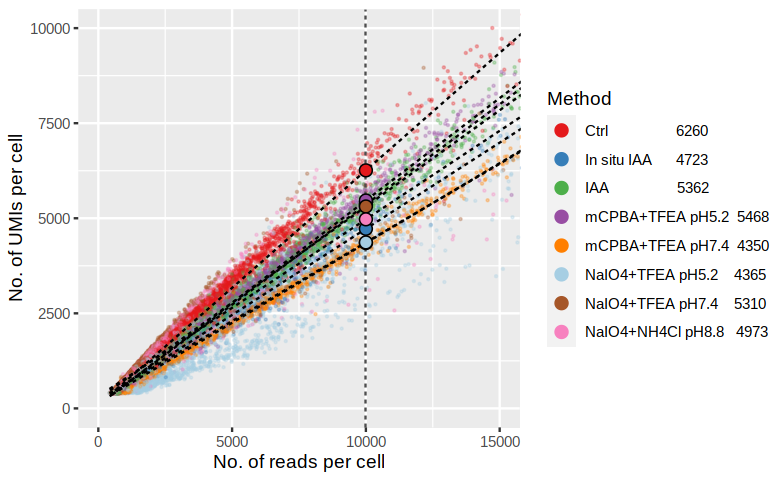

In [62]:
options(repr.plot.width=6.5,repr.plot.height=4)
ggplot(subset(pre_dat, nUMI >400 & reads <30000),aes(reads,nUMI,col=sample)) + 
  geom_point(data = sample_frac(subset(pre_dat, nUMI >400 & reads <30000),0.5),
                  size=.2,shape=19,alpha=.3) + 
  geom_smooth(method="lm",formula = y ~ x,se=F,size=.5,linetype=2,aes(group=sample),col="black") +
  scale_color_manual("Method",values=my.col.3[1:8],labels=c('Ctrl                 6260',
                                                      'In situ IAA      4723',
                                                      'IAA                 5362',
                                                      'mCPBA+TFEA pH5.2  5468',
                                                      'mCPBA+TFEA pH7.4  4350',
                                                      'NaIO4+TFEA pH5.2    4365',
                                                      'NaIO4+TFEA pH7.4    5310',
                                                      'NaIO4+NH4Cl pH8.8   4973')) +
  scale_x_continuous(breaks=seq(0,30000,5000),labels=seq(0,30000,5000)) + 
  coord_cartesian(xlim = c(0,15000),ylim = c(0,10000)) + 
  geom_vline(xintercept = 10000,col="grey30",linetype="dashed") + 
  geom_point(data = df.extra2,  fill = my.col.3[1:8],col = 'black',shape = 21,size=3) +
  ylab('No. of UMIs per cell')+
  xlab('No. of reads per cell')+
  guides(colour = guide_legend(ncol=1,override.aes=list(size=3,alpha=1))) 

# Fig2E,Fig2F

In [ ]:
#load raw h5ad form dynast
file_names <- list.dirs(path, full.names = F, recursive = F)
adata_list <- list()
for (name in file_names) {
        adata_list[[name]] <- read_h5ad(paste0(name, "/adata.h5ad"))
    }
    mat_list <- list()
    for (name in file_names) {
        mat_list[[name]] <- mat.tag(name, adata_list[[name]]$X)
    }

In [ ]:
#Creating a seurat object
sc.list <- list()
sc.post <- list()
 for (name in file_names) {
    sc.list[[name]] <- CreateSeuratObject(counts = mat_list[[name]], min.cells = 10, 
        min.features = 0)
    grep("^mt-", rownames(sc.list[[name]]@assays$RNA@counts), value = T)
    sc.list[[name]][["percent.mt"]] <- PercentageFeatureSet(sc.list[[name]], pattern = "^mt-")
    sc.list[[name]]@meta.data$sample <- str_split(sc.list[[name]]@meta.data$orig.ident,'b',n=2,simplify = T)[,1]
    sc.list[[name]]@meta.data$batch <- str_split(sc.list[[name]]@meta.data$orig.ident,'b',n=2,simplify = T)[,2]
    sc.list[[name]]@meta.data$barcode <- rownames(sc.list[[name]]@meta.data)
    sc.list[[name]]@meta.data$cell <- str_split(sc.list[[name]]@meta.data$barcode,'_',n=2,simplify = T)[,2]
    sc.list[[name]] <- subset(sc.list[[name]],percent.mt < 10 & nFeature_RNA > 400 & nFeature_RNA < 4000 )
    sc.list[[name]] <- NormalizeData(sc.list[[name]]) %>% FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>%
     ScaleData(vars.to.regress = c('nCount_RNA','percent.mt'))
    sc.post[[name]] <- RunPCA(sc.list[[name]],features = VariableFeatures(object = sc.list[[name]])) %>%
     FindNeighbors(dims = 1:10) %>% FindClusters(resolution = 0.4)%>%
     RunTSNE(dims = 1:10) %>% RunUMAP(dims = 1:10,umap.method = 'umap-learn')
}

In [ ]:
qsavem(sc.list,sc.postfile = 'each_sample_umap.qs')

In [63]:
qload(file = 'each_sample_umap.qs')
#Import the single cell data of all samples

In [64]:
sc.list

$Ctrlb2
An object of class Seurat 
9230 features across 1025 samples within 1 assay 
Active assay: RNA (9230 features, 2000 variable features)

$Ctrlb3
An object of class Seurat 
14776 features across 1672 samples within 1 assay 
Active assay: RNA (14776 features, 2000 variable features)

$Ctrlbinsitu
An object of class Seurat 
14644 features across 2796 samples within 1 assay 
Active assay: RNA (14644 features, 2000 variable features)

$IAAb1
An object of class Seurat 
13388 features across 1659 samples within 1 assay 
Active assay: RNA (13388 features, 2000 variable features)

$IAAb3
An object of class Seurat 
15317 features across 2203 samples within 1 assay 
Active assay: RNA (15317 features, 2000 variable features)

$IAAb4
An object of class Seurat 
18459 features across 1719 samples within 1 assay 
Active assay: RNA (18459 features, 2000 variable features)

$`in-situ-IAAb1`
An object of class Seurat 
10528 features across 1587 samples within 1 assay 
Active assay: RNA (10528 feat

In [ ]:
#Integrate Data
sc.anchors <- FindIntegrationAnchors(object.list = sc.list)
sc.int <- IntegrateData(anchorset = sc.anchors)


In [ ]:
sc.int <- ScaleData(sc.int,vars.to.regress = c('nCount_RNA','percent.mt')) %>%
     RunPCA(features = VariableFeatures(sc.int)) %>%
     FindNeighbors(dims = 1:10) %>% FindClusters(resolution = c(0.05，0.4))%>%
     RunUMAP(dims = 1:10,umap.method = 'umap-learn')

In [ ]:
qsavem(sc.anchors,sc.int,file = 'sc.all.x_CCA_intergrate.qs')

In [65]:
qload('sc.all.x_CCA_intergrate.qs')

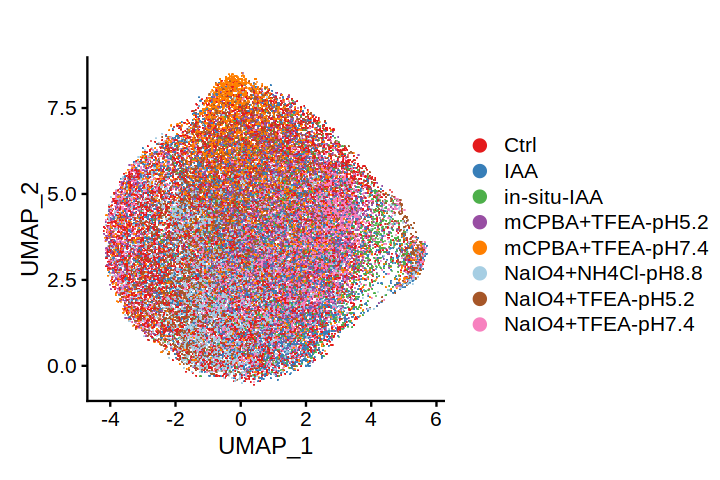

In [66]:
options(repr.plot.width=6, repr.plot.height=4) 
scCustomize::DimPlot_scCustom(seurat_object = sc.int, group.by = "sample",colors_use=alpha(my.col.3,.5),raster = T,pt.size = 1)+ggtitle('')

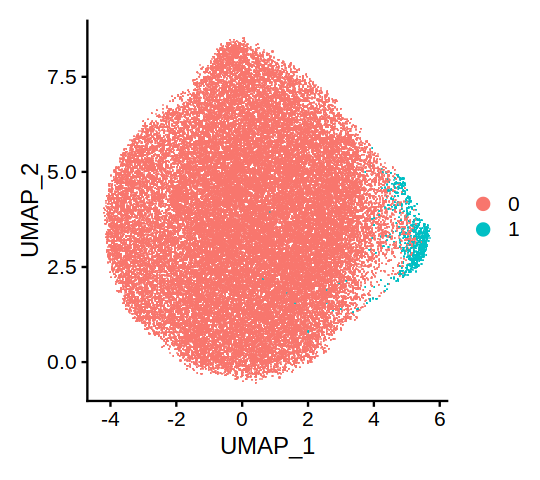

In [70]:
options(repr.plot.width=4.5, repr.plot.height=4)
DimPlot(sc.int, reduction = "umap",raster = T,pt.size = 1)

# Fig2G

In [18]:
umi_plot_position <- function(plot.file,sample,gene,start,end){
    a <- fread(plot.file)
    names(a) <- c("read","gene","cell","UMI","chr","bp","strand","base","qual")
    table(a$base)
    print(length(unique(a$cell)))
    a2 <- a %>% group_by(gene,cell,UMI,chr,bp,base) %>% dplyr::summarize(count=n())
    a3 <-  reshape2::dcast(a2,gene+cell+UMI+chr+bp~base,value.var = "count")
    if (!"C" %in% unique(a2$base)) {
      a3$C <- 0
    }
    a3[is.na(a3)] <- 0

    a3$prop.C <- a3$C/(a3$C + a3$T)

    a3$type <- "none"
    a3$type <- ifelse(a3$prop.C > 0.5, "more.than.half.C",
                  ifelse(a3$prop.C == 0, "all.T",
                         ifelse(a3$prop.C == 1, "all.C", "lessORequal.half.C")))

    a3$defined.base <- "none"
    a3$defined.base <- ifelse(a3$prop.C <= 0.5, "T", "C")
    table(a3$defined.base)
    table(a3$type)
    table(a3$gene)
    gene.in <- gene
    gene.plot <- a3 %>% filter(gene %in% gene.in) 
    top1.cells <- names(sort(table(gene.plot$cell),decreasing = T))[1] ## take out top1 cells
    gene.plot <- gene.plot %>%  filter(cell %in% top1.cells)
    gene.plot$value <- 0
    # 检查是否存在 defined.base == "C" 的行
    if (any(gene.plot$defined.base == "C")) {
      # 如果存在，则将这些行的 value 设置为 1
      gene.plot[gene.plot$defined.base == "C", ]$value <- 1
    } else {
      # 如果不存在，则跳过操作
      message("No 'C' in defined.base, skipping assignment.")
    }

    gene.plot.UMI <- dcast(gene.plot,UMI~bp,value.var = "value")
    gene.plot.UMI[is.na(gene.plot.UMI)] <- 0

    gene.plot.UMI2 <- as.matrix(gene.plot.UMI[,-1])
    rownames(gene.plot.UMI2) <- gene.plot.UMI$UMI
    mutation.number <- rowSums(gene.plot.UMI2)

    gene.plot$num.mut <- mutation.number[as.character(gene.plot$UMI)]
    gene.plot$class <- "steady"
    if (any(gene.plot$num.mut > 0)) {
      # 如果存在，则将这些行的 value 设置为 nascent
      gene.plot[gene.plot$num.mut > 0,]$class <- "nascent"
    } else {
      # 如果不存在，则跳过操作
      message("No 'nascent' in defined.base, skipping assignment.")
    }
    gene.plot %>% select(UMI,class)  %>% distinct()  -> gene.Test
    table(gene.Test$class)

    gene.plot$CT <- gene.plot$C + gene.plot$T

    gene.plot.xx <- gene.plot %>% select(UMI,class,num.mut) %>% distinct() %>% arrange(class,desc(num.mut))
    gene.plot.xx$index <- rev(1:dim(gene.plot.xx)[1])
    gene.plot <- gene.plot %>% group_by(UMI,class,num.mut) %>% inner_join(gene.plot.xx)
    head(gene.plot)

    gene.plot.p1 <- gene.plot %>% filter(defined.base=="T")
    gene.plot.p2 <- gene.plot %>% filter(defined.base=="C")

    gene.plot$index <- factor(gene.plot$index)
    gene.plot.p1$index <- factor(gene.plot.p1$index)
    gene.plot.p2$index <- factor(gene.plot.p2$index)

    n_steady <- length(gene.Test[gene.Test$class == 'steady',]$class)    
    n_nascent <- length(gene.Test[gene.Test$class == 'nascent',]$class)
    b <- data.frame(class=c('nascent','steady'),num=c(n_nascent,n_steady))
    library(ggrastr)
    options(repr.plot.height=3.5,repr.plot.width=6)
    plot <- ggplot(gene.plot,aes(bp,index)) + 
       geom_point_rast(data=gene.plot.p1,aes(bp,index),shape=1,col="grey60",alpha=.5,size=0.3,raster.dpi = getOption("ggrastr.default.dpi", 300)) + 
       scale_color_gradient("T>C coverage",low = "blue",high = "red",,limits = c(1, 5)) + 
       geom_point_rast(data=gene.plot.p2,aes(bp,index,col=C),shape=4,size=0.5,raster.dpi = getOption("ggrastr.default.dpi", 300)) + 
       scale_y_discrete(labels=NULL) + 
       coord_cartesian(xlim = c(start,end))+
       theme_bw() + ggtitle(paste(sample,"  ",gene.in,"  ",round(b[1,2]/(b[1,2]+b[2,2])*100,2),"%")) + 
       ylab(paste(b[1,2]+b[2,2],"UMIs (",b[1,2] ," label, ",b[2,2]," unlabel)"))
       #ylab(paste(b[1,2]+b[2,2],"UMIs (",b[1,2] ," label, ",b[2,2]," unlabel)",round(b[1,2]/(b[1,2]+b[2,2])*100,2),"%"))
return(plot)
}

In [19]:
setwd('./Fig2G_data')
merge_plot_tubb4b <- function(gene,start,end){
    Ctrl <- umi_plot_position('Ctrl_tubb4b_plot_ATCCCGCCGGTG.tsv','Ctrl',gene,start,end)
    IAA <- umi_plot_position('IAA_tubb4b_plot_GGTCGTGATAAT.tsv','On-beads IAA',gene,start,end)
    insitu.iaa <- umi_plot_position('insitu-IAA_tubb4b_plot_GGTCATGACGCT.tsv','In-situ IAA',gene,start,end)
    mCPBA5.2 <- umi_plot_position('mCPBA+TFEA-pH5.2_tubb4b_plot_TGCAGCCCCTCT.tsv','mCPBA+TFEA,pH5.2',gene,start,end)
    mCPBA7.4 <- umi_plot_position('mCPBA+TFEA-pH7.4_tubb4b_plot_CCCCCAGCCGCT.tsv','mCPBA+TFEA,pH7.4',gene,start,end)
    NaIO4_5.2 <- umi_plot_position('NaIO4+TFEA-pH5.2_tubb4b_plot_AAAATACACAAC.tsv','NaIO4+TFEA,pH5.2',gene,start,end)
    NaIO4_7.4 <- umi_plot_position('NaIO4+TFEA-pH7.4_tubb4b_plot_CATCGTCTTCAA.tsv','NaIO4+TFEA,pH7.4',gene,start,end)
    NH4Cl <- umi_plot_position('NaIO4+NH4Cl-pH8.8_tubb4b_plot_AAATGGAACTGC.tsv','NaIO4+NH4Cl,pH8.8',gene,start,end)
    library(cowplot)
    legend <- get_legend(Ctrl)

    plots <- plot_grid(Ctrl + theme(legend.position="none"), 
                       insitu.iaa + theme(legend.position="none"), 
                       IAA + theme(legend.position="none"), 
                       mCPBA5.2 + theme(legend.position="none"), 
                       mCPBA7.4 + theme(legend.position="none"), 
                       NaIO4_5.2 + theme(legend.position="none"), 
                       NaIO4_7.4 + theme(legend.position="none"), 
                       NH4Cl + theme(legend.position="none"), 
                       ncol = 4)

    final_plot <- plot_grid(plots, legend, ncol = 2, rel_widths = c(1, .1))
    return(final_plot)
}

In [20]:
options(warn = -1) 
tubb4b_single_cell <- merge_plot_tubb4b('tubb4b',5864600,5865125)

[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`

Attaching package: ‘cowplot’


The following object is masked from ‘package:ggthemes’:

    theme_map




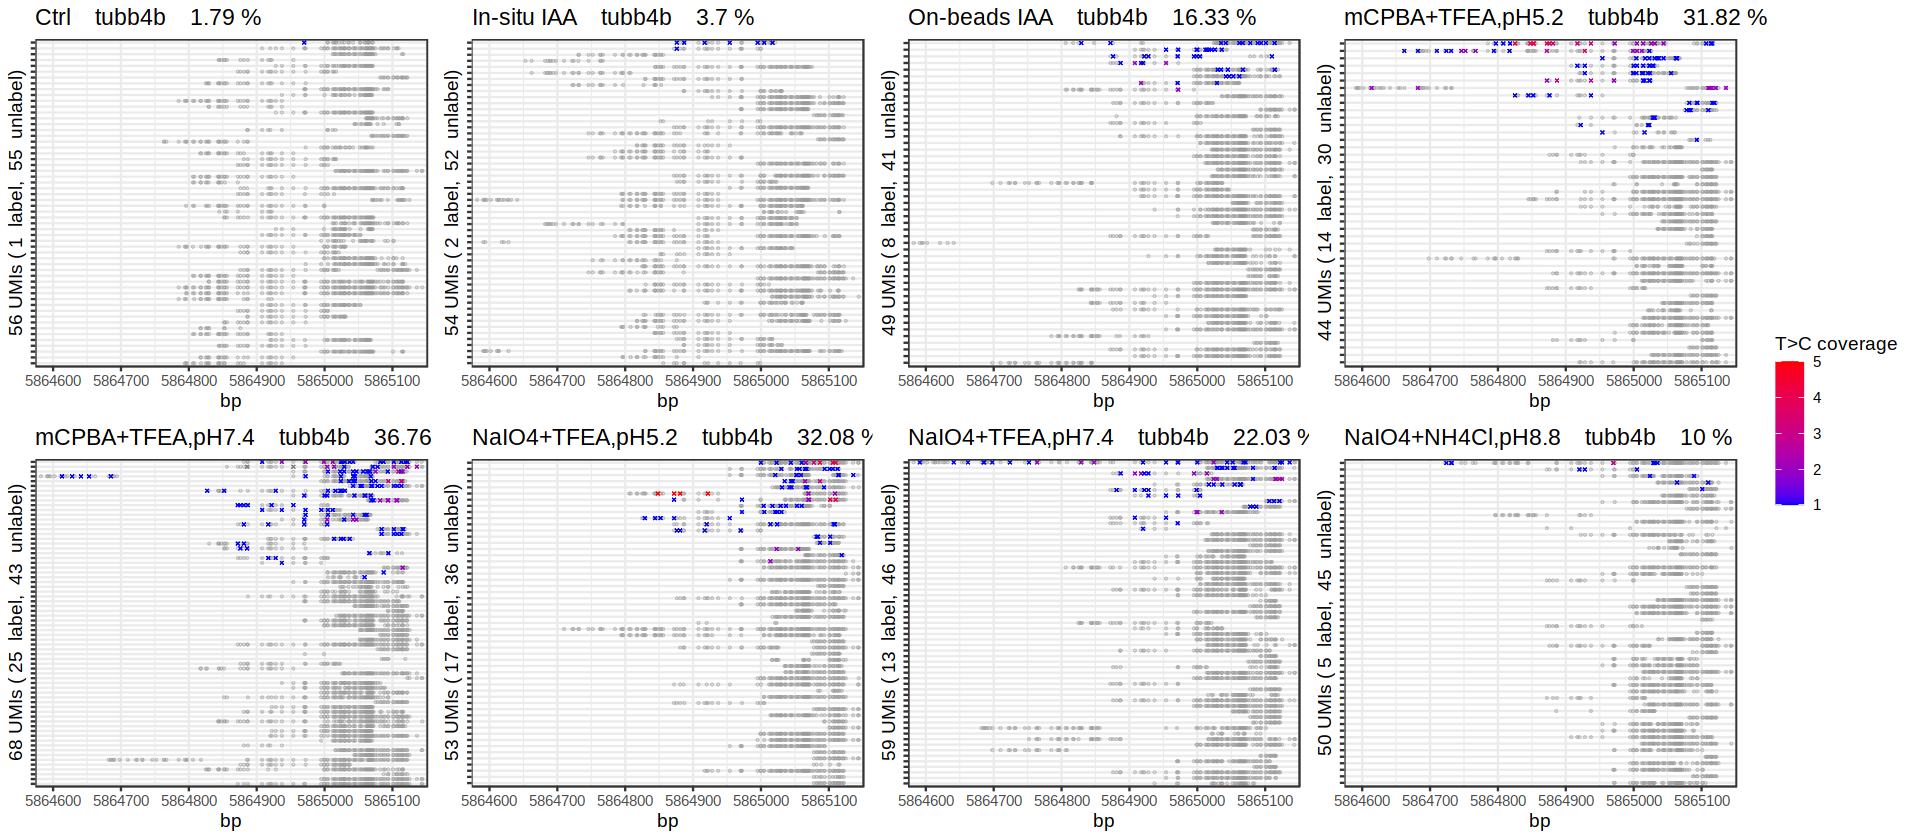

In [21]:
options(repr.plot.height=7,repr.plot.width=16)
tubb4b_single_cell

# FigS3A，S3B

In [45]:
setwd('./FigS3_data')
merge_plot_ccnd1 <- function(gene,start,end){
    Ctrl <- umi_plot_position('Ctrl_ccnd1_plot_GCACGAGCTCCA.tsv','Ctrl',gene,start,end)
    IAA <- umi_plot_position('IAA_ccnd1_plot_CGTCGTCATCCC.tsv','On-beads IAA',gene,start,end)
    insitu.iaa <- umi_plot_position('insitu-IAA_ccnd1_plot_AAGCCCCTACAG.tsv','In-situ IAA',gene,start,end)
    mCPBA5.2 <- umi_plot_position('mCPBA+TFEA-pH5.2_ccnd1_plot_CCACTGGTTATT.tsv','mCPBA+TFEA,pH5.2',gene,start,end)
    mCPBA7.4 <- umi_plot_position('mCPBA+TFEA-pH7.4_ccnd1_plot_CGTTTCTCACGA.tsv','mCPBA+TFEA,pH7.4',gene,start,end)
    NaIO4_5.2 <- umi_plot_position('NaIO4+TFEA-pH5.2_ccnd1_plot_GTGTTAAGCCTC.tsv','NaIO4+TFEA,pH5.2',gene,start,end)
    NaIO4_7.4 <- umi_plot_position('NaIO4+TFEA-pH7.4_ccnd1_plot_ACCTAGTCCATC.tsv','NaIO4+TFEA,pH7.4',gene,start,end)
    NH4Cl <- umi_plot_position('NaIO4+NH4Cl-pH8.8_ccnd1_plot_CTGCCCCACGAT.tsv','NaIO4+NH4Cl,pH8.8',gene,start,end)
    library(cowplot)

    legend <- get_legend(Ctrl)


    plots <- plot_grid(Ctrl + theme(legend.position="none"), 
                       insitu.iaa + theme(legend.position="none"), 
                       IAA + theme(legend.position="none"), 
                       mCPBA5.2 + theme(legend.position="none"), 
                       mCPBA7.4 + theme(legend.position="none"), 
                       NaIO4_5.2 + theme(legend.position="none"), 
                       NaIO4_7.4 + theme(legend.position="none"), 
                       NH4Cl + theme(legend.position="none"), 
                       ncol = 4)


    final_plot <- plot_grid(plots, legend, ncol = 2, rel_widths = c(1, .1))
    return(final_plot)
}

In [46]:
ccnd1_p <- merge_plot_ccnd1('ccnd1',54670000,54678000)

[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


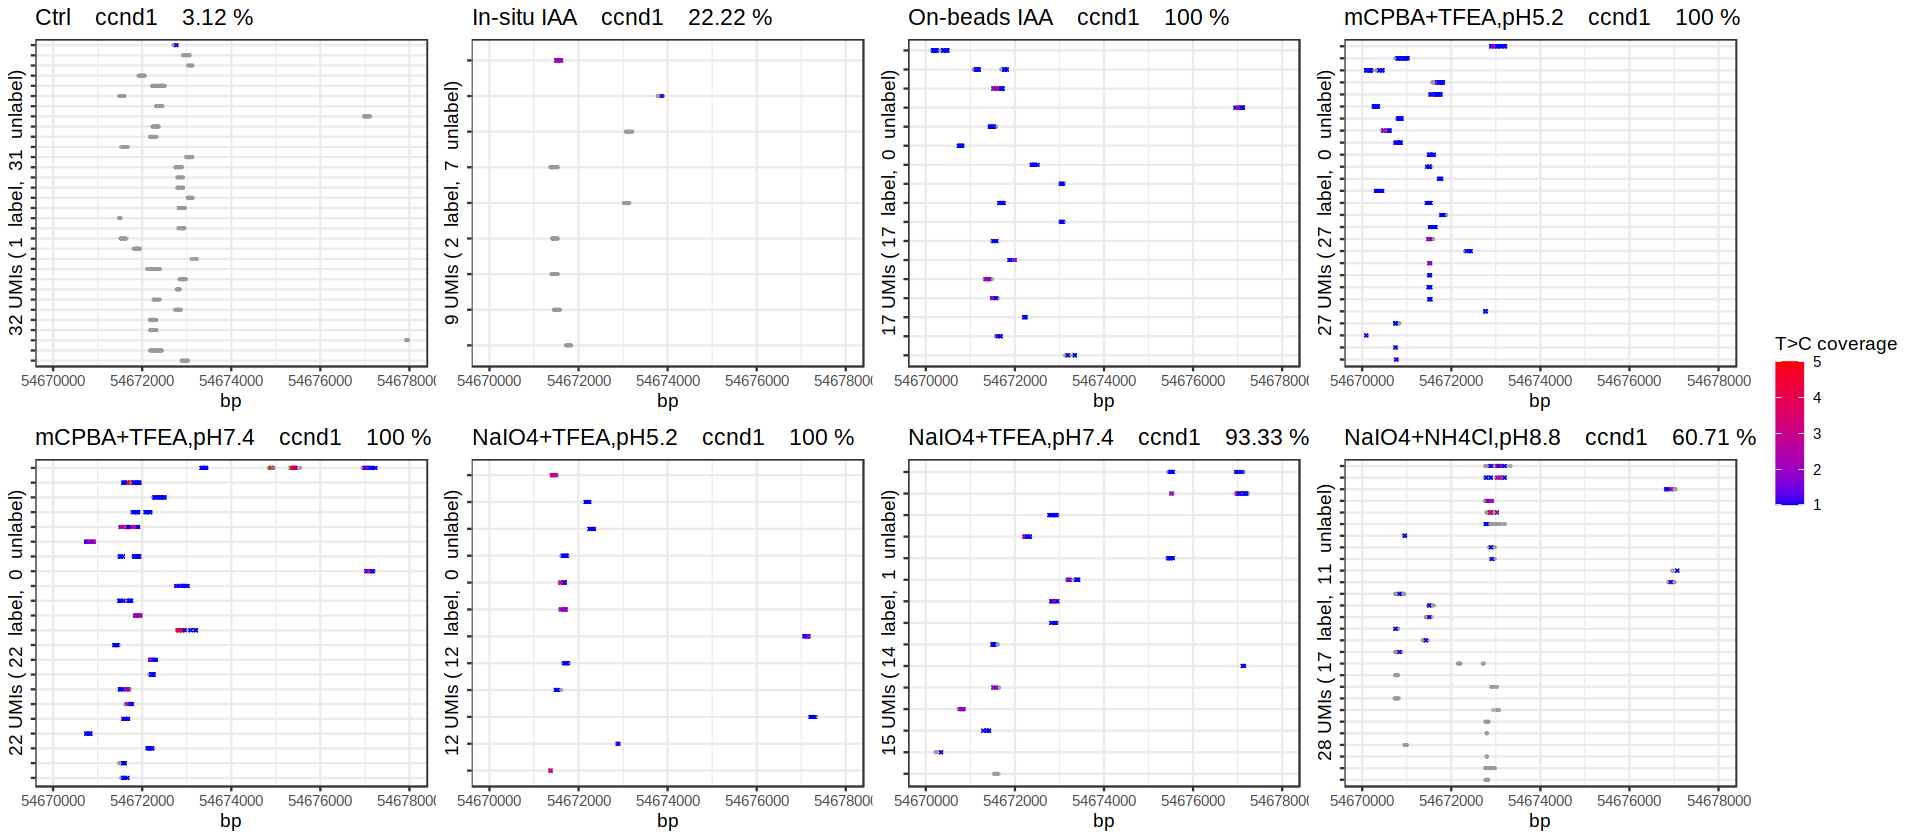

In [47]:
options(repr.plot.height=7,repr.plot.width=16)
ccnd1_p

In [48]:
merge_plot_rplp0 <- function(gene,start,end){
    Ctrl <- umi_plot_position('Ctrl_rplp0_plot_CCCAGTACCCCC.tsv','Ctrl',gene,start,end)
    IAA <- umi_plot_position('IAA_rplp0_plot_GCCGCACAACCG.tsv','On-beads IAA',gene,start,end)
    insitu.iaa <- umi_plot_position('insitu-IAA_rplp0_plot_TGCCATAACATA.tsv','In-situ IAA',gene,start,end)
    mCPBA5.2 <- umi_plot_position('mCPBA+TFEA-pH5.2_rplp0_plot_CGACTGCTAGCT.tsv','mCPBA+TFEA,pH5.2',gene,start,end)
    mCPBA7.4 <- umi_plot_position('mCPBA+TFEA-pH7.4_rplp0_plot_CGAACGTATGCC.tsv','mCPBA+TFEA,pH7.4',gene,start,end)
    NaIO4_5.2 <- umi_plot_position('NaIO4+TFEA-pH5.2_rplp0_plot_GCAACGCACTCG.tsv','NaIO4+TFEA,pH5.2',gene,start,end)
    NaIO4_7.4 <- umi_plot_position('NaIO4+TFEA-pH7.4_rplp0_plot_CGCTTGCATCGC.tsv','NaIO4+TFEA,pH7.4',gene,start,end)
    NH4Cl <- umi_plot_position('NaIO4+NH4Cl-pH8.8_rplp0_plot_GTGTAGCGATAG.tsv','NaIO4+NH4Cl,pH8.8',gene,start,end)
    library(cowplot)

    legend <- get_legend(Ctrl)


    plots <- plot_grid(Ctrl + theme(legend.position="none"), 
                       insitu.iaa + theme(legend.position="none"), 
                       IAA + theme(legend.position="none"), 
                       mCPBA5.2 + theme(legend.position="none"), 
                       mCPBA7.4 + theme(legend.position="none"), 
                       NaIO4_5.2 + theme(legend.position="none"), 
                       NaIO4_7.4 + theme(legend.position="none"), 
                       NH4Cl + theme(legend.position="none"), 
                       ncol = 4)


    final_plot <- plot_grid(plots, legend, ncol = 2, rel_widths = c(1, .1))
    return(final_plot)
}

In [49]:
rplp0_p <- merge_plot_rplp0('rplp0',1950600,1953100)

[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
No 'C' in defined.base, skipping assignment.

No 'nascent' in defined.base, skipping assignment.

Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
No 'C' in defined.base, skipping assignment.

No 'nascent' in defined.base, skipping assignment.

Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


[1] 1


`summarise()` has grouped output by 'gene', 'cell', 'UMI', 'chr', 'bp'. You can override using the `.groups` argument.
Joining with `by = join_by(UMI, num.mut, class)`


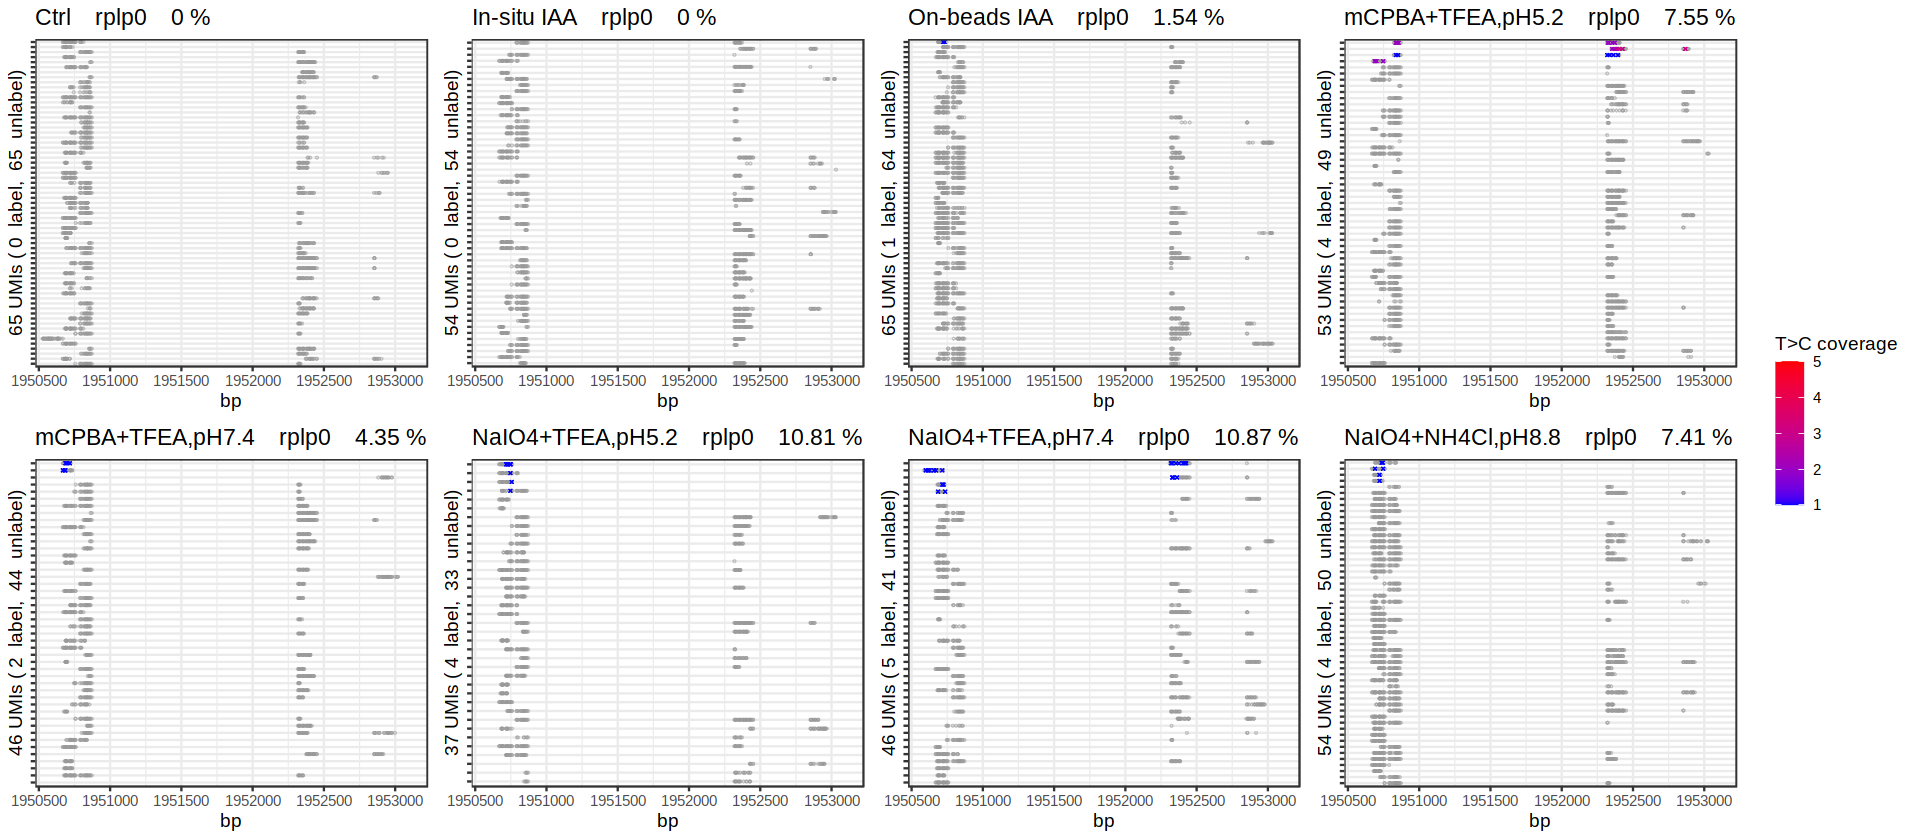

In [ ]:
options(repr.plot.height=7,repr.plot.width=16)
rplp0_p

# Fig2H

In [ ]:
mat.tag <- function(tag,mat){
    tmp.mat <- t(as.matrix(mat))
    colnames(tmp.mat) <- paste(tag,colnames(tmp.mat),sep = '_')
    return(tmp.mat)
}

# function from URD
dsCombineDGE <- function(list.dge) {
  all.gene.names <- sort(unique(unlist(lapply(list.dge, function(x) rownames(x)))))
  # Expand each data frame to include a bunch of NAs where a gene was missing
  for (i in 1:length(list.dge)) {
    genes.not.in.this.matrix <- setdiff(all.gene.names, rownames(list.dge[[i]]))
    if (length(genes.not.in.this.matrix) > 0) {
      add.matrix <- Matrix(data=rep(0, length(genes.not.in.this.matrix) * dim(list.dge[[i]])[2]), nrow=length(genes.not.in.this.matrix),
                           sparse=T)
      rownames(add.matrix) <- genes.not.in.this.matrix
      list.dge[[i]] <- rbind(list.dge[[i]], add.matrix)
      list.dge[[i]] <- list.dge[[i]][all.gene.names,]
    }
  }
  # Now cbind all the data frames
  combined.dge <- do.call(cbind,list.dge)
  return(combined.dge)
}
#load raw h5ad form dynast                                
sc_read <- function (path) 
{
    setwd(path)
    file_names <- list.dirs(path, full.names = F, recursive = F)
    adata_list <- list()
    for (name in file_names) {
        adata_list[[name]] <- read_h5ad(paste0(name, "/adata.h5ad"))
    }
    mat_list <- list()
    for (name in file_names) {
        mat_list[[name]] <- mat.tag(name, adata_list[[name]]$X)
    }
    mat.all <- dsCombineDGE(mat_list)
    sc <- CreateSeuratObject(counts = mat.all, min.cells = 0, 
        min.features = 0)
    grep("^mt-", rownames(sc@assays$RNA@counts), value = T)
    sc[["percent.mt"]] <- PercentageFeatureSet(sc, pattern = "^mt-")
    sc@meta.data$sample <- str_split(sc@meta.data$orig.ident,'b',n=2,simplify = T)[,1]
    sc@meta.data$batch <- str_split(sc@meta.data$orig.ident,'b',n=2,simplify = T)[,2]
    sc@meta.data$barcode <- rownames(sc@meta.data)
    sc@meta.data$cell <- str_split(sc@meta.data$barcode,'_',n=2,simplify = T)[,2]
    return(sc)
}
sc_layer_read <- function(path,layer){
    setwd(path)
    file_names <- list.dirs(path,full.names = F,recursive = F)
    adata_list <- list()

    for (name in file_names) {
      adata_list[[name]] <- read_h5ad(paste0(name, "/adata.h5ad"))
    }
    mat_list <- list()

    for (name in file_names) {
      mat_list[[name]] <- mat.tag(name,adata_list[[name]]$layers[layer])
    }
    mat.all <- dsCombineDGE(mat_list)
    sc <- CreateSeuratObject(counts = mat.all,min.cells = 0,min.features = 0)
    grep("^mt-",rownames(sc@assays$RNA@counts),value=T)
    #add percent.mt
    sc[["percent.mt"]] <- PercentageFeatureSet(sc, pattern = "^mt-")
    sc@meta.data$sample <- str_split(sc@meta.data$orig.ident,'b',n=2,simplify = T)[,1]
    sc@meta.data$batch <- str_split(sc@meta.data$orig.ident,'b',n=2,simplify = T)[,2]
    sc@meta.data$barcode <- rownames(sc@meta.data)
    sc@meta.data$cell <- str_split(sc@meta.data$barcode,'_',n=2,simplify = T)[,2]
    return(sc)
}

In [ ]:
sc.total <- sc_read('dynast_result/estimate')

In [ ]:
sc.label <- sc_layer_read('dynast_result/estimate','X_l_TC')

In [ ]:
sc.total.sub <- subset(sc.total,barcode %in% sc.int$barcode)
sc.label.sub <- subset(sc.label,barcode %in% sc.int$barcode)

In [ ]:
steady.cells <- rownames(sc.int@meta.data)[sc.int@meta.data$seurat_clusters == "0" & 
                                           sc.int@meta.data$sample %in% c("mCPBA+TFEA-pH5.2","mCPBA+TFEA-pH7.4")]
cycling.cells <- rownames(sc.int@meta.data)[sc.int@meta.data$seurat_clusters == "1" & 
                                           sc.int@meta.data$sample %in% c("mCPBA+TFEA-pH5.2","mCPBA+TFEA-pH7.4")]


In [ ]:
label.umi <- rowSums(sc.label.sub@assays$RNA@counts[,steady.cells])
total.umi <- rowSums(sc.total.sub@assays$RNA@counts[,steady.cells])

In [ ]:
qsavem(label.umi,total.umi,file='./Fig2H_data/fig2H.rds')

In [27]:
qload('./Fig2H_data/fig2H.rds')

In [30]:
label.umi[1:10]
total.umi[1:10]

a1cf    a2ml    aaas    aacs   aadac aadacl4   aadat   aagab   aak1a   aak1b 
      3       5     370     916      15       2      43    1035     322     370

a1cf    a2ml    aaas    aacs   aadac aadacl4   aadat   aagab   aak1a   aak1b 
     10      14     890    1133      40       5      67    1314     430     501

In [31]:
## take genes UMI total more than 30
total.umi2 <- total.umi[total.umi >= 30]
length(total.umi2)

[1] 17766

In [32]:
label.umi2 <- label.umi[names(total.umi2)]

In [33]:
# Calculate half-life
hf.mcpba.steady <- sapply(1:length(total.umi2),function(x){
    theta = label.umi2[x]/total.umi2[x]
    a = log(1-theta)
    b = -4*log(2)
    return(b/a)
})

In [34]:
theta.mcpba.steady <- sapply(1:length(total.umi2),function(x){
    return(label.umi2[x]/total.umi2[x])
})

In [35]:
# Calculate decay rate
gamma.mcpba.steady <-sapply(1:length(total.umi2),function(x){
    theta = label.umi2[x]/total.umi2[x]
    gamma = -log(1-theta)/4
    return(gamma)
})

In [37]:
hf.mcpba.steady.df <- data.frame('steady half-life'=hf.mcpba.steady,gene=names(hf.mcpba.steady))

In [38]:
hf.mcpba.steady.df.filt <- subset(hf.mcpba.steady.df,log10(steady.half.life)<2)

In [39]:
hf.plot.steady <- hf.mcpba.steady.df.filt %>%
  arrange(steady.half.life) %>%  
  mutate(rank = row_number()) 
hf.plot.steady$bin <- cut(hf.plot.steady$steady.half.life,
                breaks = quantile(hf.plot.steady$steady.half.life, probs = seq(0, 1, by = 0.1)),
                include.lowest = TRUE,
                labels = FALSE)

In [40]:
fast_hf_label <- filter(hf.plot.steady,gene %in% c('ccnd1','tubb4b','mki67'))
slow_hf_label <-hf.plot.steady[hf.plot.steady$gene %in% c('rplp0','gapdh','rpl13a'),] 

In [41]:
fast_hf_label
slow_hf_label

,steady.half.life,gene,rank,bin
,<dbl>,<chr>,<int>,<int>
ccnd1,1.437182,ccnd1,1366,1
mki67,1.810448,mki67,4818,3
tubb4b,5.772857,tubb4b,13790,8


,steady.half.life,gene,rank,bin
,<dbl>,<chr>,<int>,<int>
rpl13a,14.99661,rpl13a,16530,10
rplp0,31.62740,rplp0,17272,10
gapdh,44.55709,gapdh,17458,10


In [43]:
options(repr.plot.width=4,repr.plot.height=4)
hf_plot <- ggplot(hf.plot.steady,aes(rank,log10(steady.half.life))) + 
    geom_rect(aes(xmin=-Inf, xmax=Inf, ymin=log10(min(hf.plot.steady[hf.plot.steady$bin==10,]$steady.half.life)), ymax=Inf),fill='#C5DEEA',alpha = .2)+
    geom_rect(aes(xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=log10(max(hf.plot.steady[hf.plot.steady$bin==1,]$steady.half.life))),fill='#F6C7AA',alpha = .2)+
    geom_hline(yintercept = log10(min(hf.plot.steady[hf.plot.steady$bin==10,]$steady.half.life)),linetype ='dashed',colour="#0658A5")+
    geom_hline(yintercept = log10(max(hf.plot.steady[hf.plot.steady$bin==1,]$steady.half.life)),linetype ='dashed',colour="#E41A1C")+
    geom_point_rast(size=0.5)+ coord_cartesian(ylim = c(0,2))+
    geom_point(fast_hf_label,mapping = aes(x=rank , y= log10(steady.half.life)), size = 3,color='#DF020E',alpha=1)+
    geom_point(slow_hf_label,mapping = aes(x=rank , y= log10(steady.half.life)), size = 3,color='#333E8E',alpha=1)+
    ggrepel::geom_text_repel(fast_hf_label,mapping = aes(x=rank , y= log10(steady.half.life),label=gene),nudge_x = 1000,color='#DF020E',size = 5)+
    ggrepel::geom_text_repel(slow_hf_label ,mapping = aes(x=rank,y= log10(steady.half.life),label=gene),nudge_x = -1000,color='#333E8E',size = 5)+
    theme_cowplot(font_size = 15)+
    xlab('Rank')+ylab('Log10 half-life')

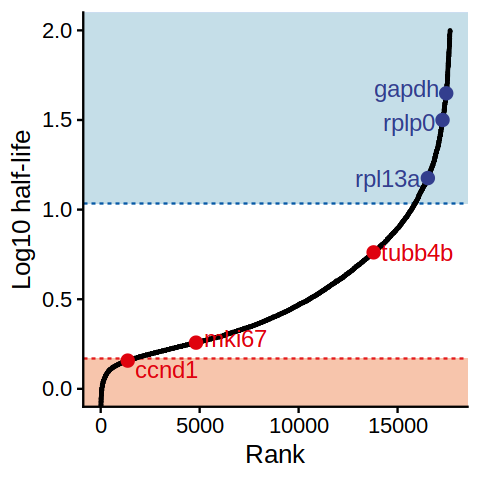

In [44]:
options(repr.plot.width=4,repr.plot.height=4)
hf_plot

# FigS2 A

In [75]:
library(RCurl)
library(AnnotationHub)
cell_cycle_genes <- read.csv("seurat/Danio_rerio_cell_cycle.csv")
# Connect to AnnotationHub
ah <- AnnotationHub()
# Access the Ensembl database for organism
ahDb <- query(ah, 
              pattern = c("Danio rerio", "EnsDb"), 
              ignore.case = TRUE)
# Acquire the latest annotation files
id <- ahDb %>%
        mcols() %>%
        rownames() %>%
        tail(n = 1)
# Download the appropriate Ensembldb database
edb <- ah[[id]]

# Extract gene-level information from database
annotations <- genes(edb, 
                     return.type = "data.frame")
# Select annotations of interest
annotations <- annotations %>%
        dplyr::select(gene_id, gene_name, seq_name, gene_biotype, description)
# Get gene names for Ensembl IDs for each gene
cell_cycle_markers <- dplyr::left_join(cell_cycle_genes, annotations, by = c("geneID" = "gene_id"))

# Acquire the S phase genes
s_genes <- cell_cycle_markers %>%
        dplyr::filter(phase == "S") %>%
        pull("gene_name")
        
# Acquire the G2M phase genes        
g2m_genes <- cell_cycle_markers %>%
        dplyr::filter(phase == "G2/M") %>%
        pull("gene_name")
g2m_genes[grep('CKS2',g2m_genes)] <- 'cks2'


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


Canno

In [76]:
cycle_gene_exp <- AverageExpression(sc.int,
                                   features = c(s_genes,g2m_genes),
                                   group.by = 'integrated_snn_res.0.05',
                                   slot = 'data') 
cycle_gene_exp <- as.data.frame(cycle_gene_exp$RNA)

Warning message:
"The following 25 features were not found in the integrated assay: cdc45, pola1, mcm4, gmnn, e2f8, gins2, nasp, brip1, dscc1, dtl, cdca7a, chaf1b, usp1, fen1, exo1, g2e3, cbx5, ctcf, nek2, cks2, kif11, anp32e, lbr, ccnb2, cks1b"


In [79]:
library(ComplexHeatmap)
library(circlize)
col_fun = colorRamp2(c(0, 0.5,1), c("#2878b5","white", "#D95444"))

In [120]:
packageVersion('ComplexHeatmap')
packageVersion('cowplot')

[1] '2.14.0'

[1] '1.1.1'

In [80]:
df_cycle <- data.frame(colnames(cycle_gene_exp))
colnames(df_cycle) <- 'class'
top_anno_cycle = HeatmapAnnotation(df = df_cycle,
                             border = T,
                             show_annotation_name = F,
                             gp = gpar(col = 'black'),
                             col = list(class = c('0'="#F76B62",
                                                     '1'="#00B7BC")))

In [81]:
cycle_gene_exp <- t(scale(t(cycle_gene_exp),scale = T,center = F))

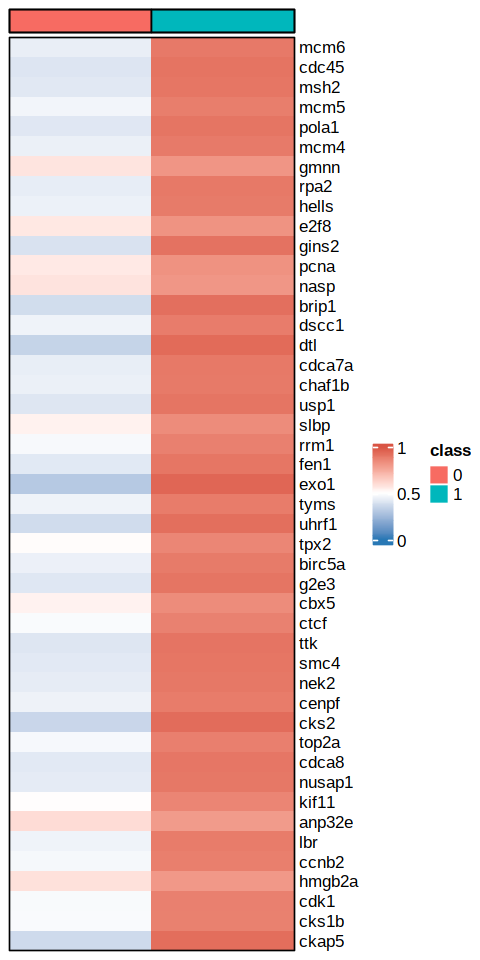

In [83]:
options(repr.plot.width = 4 ,repr.plot.height = 8)
cycle_gene_heatmap <- Heatmap(cycle_gene_exp,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = T,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
         col = col_fun,
        border = 'black',
#         rect_gp = gpar(col = "black", lwd = 0.1),
        row_names_gp = gpar(fontsize = 10),
        column_names_gp = gpar(fontsize = 10),
        top_annotation = top_anno_cycle)
cycle_gene_heatmap

In [131]:
final_genes <- c(s_genes,g2m_genes,'tubb4b','ccnd1')[!c(s_genes,g2m_genes) %in% c('gmnn','e2f8','pcna','nasp','slbp','anp32e','hmgb2a')]


In [132]:
cycle_gene_exp_final <- AverageExpression(sc.int,
                                   features = final_genes,
                                   group.by = 'integrated_snn_res.0.05',
                                   slot = 'data') 
cycle_gene_exp_final <- as.data.frame(cycle_gene_exp_final$RNA)

Warning message:
"The following 21 features were not found in the integrated assay: cdc45, pola1, mcm4, gins2, brip1, dscc1, dtl, cdca7a, chaf1b, usp1, fen1, exo1, g2e3, cbx5, ctcf, nek2, cks2, kif11, lbr, ccnb2, cks1b"


In [134]:
df_cycle_final <- data.frame(colnames(cycle_gene_exp_final))
colnames(df_cycle_final) <- 'class'
top_anno_cycle_final = HeatmapAnnotation(df = df_cycle_final,
                             border = T,
                             show_annotation_name = F,
                             gp = gpar(col = 'black'),
                             col = list(class = c('0'="#F76B62",
                                                     '1'="#00B7BC")))

In [135]:
cycle_gene_exp_final <- t(scale(t(cycle_gene_exp_final),scale = T,center = F))

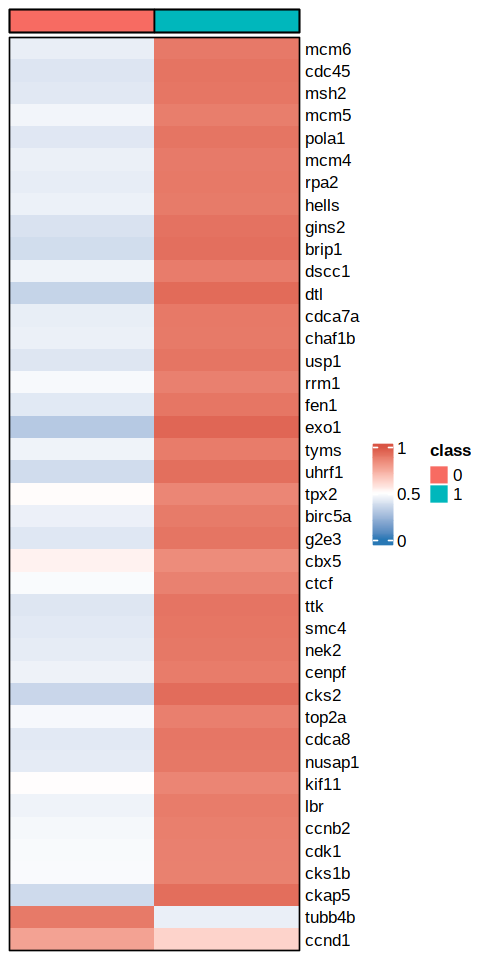

In [136]:
options(repr.plot.width = 4 ,repr.plot.height = 8)
cycle_gene_heatmap_final <- Heatmap(cycle_gene_exp_final,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = T,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
         col = col_fun,
        border = 'black',
#         rect_gp = gpar(col = "black", lwd = 0.1),
        row_names_gp = gpar(fontsize = 10),
        column_names_gp = gpar(fontsize = 10),
        top_annotation = top_anno_cycle_final)
cycle_gene_heatmap_final

In [137]:
s_genes

[1] "mcm6"   "cdc45"  "msh2"   "mcm5"   "pola1"  "mcm4"   "gmnn"   "rpa2"  
 [9] "hells"  "e2f8"   "gins2"  "pcna"   "nasp"   "brip1"  "dscc1"  "dtl"   
[17] "cdca7a" "chaf1b" "usp1"   "slbp"   "rrm1"   "fen1"   "exo1"   "tyms"  
[25] "uhrf1"

# FigS2 C

In [84]:
DefaultAssay(sc.int)

[1] "integrated"

In [85]:
DefaultAssay(sc.int) <- "RNA"

In [86]:
Idents(sc.int) <- 'integrated_snn_res.0.05'
marker.int.05 <- FindAllMarkers(sc.int,logfc.threshold = 0.25, min.pct = 0.1, only.pos = TRUE,test.use = "wilcox")

Calculating cluster 0

Calculating cluster 1



In [87]:
top100 <- marker.int.05 %>% group_by(cluster) %>% top_n(n = 100, wt = avg_log2FC)
my_top <- rbind(top100,marker.int.05 %>% dplyr::filter(gene %in% c(s_genes,g2m_genes))) %>% unique
row.names(my_top) <- my_top$gene

Warning message:
"Setting row names on a tibble is deprecated."


In [88]:
gene_cell_exp <- AverageExpression(sc.int,
                                   features = my_top$gene,
                                   group.by = 'integrated_snn_res.0.05',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)

Warning message:
"The following 99 features were not found in the integrated assay: rps9, rpl23, rps12, rps3a, rpl24, rps27a, rpl17, rplp2, rpl3, rps29, rplp1, nme2b.1, rpl36a, rpl39, prc1a, rpl8, rpl5b, rps24, rpl14, rps21, rpl10, rpl34, rpl18, rps10, rpl13a, rps28, rps11, rps16, rpl35, rps26l, rpl9, rps14, rpl6, rplp2l, aglb, rpl35a, tanc1b, ttyh3b, tox2, dner, eif1b, nfkbiaa, cdon, h3f3c, s100w, mak16, jun, sar1b, sorbs1, fkbp9, srrt, angpt1, zgc:158464, ddx21, psma6l, lsm4, adh5, ogt.1, prpf38b, rrp1, c6, ndufa3, rsrc2, ahctf1, crnkl1, CR377211.4, wbp2nl, adrm1, cul4b, fbxo11a, anxa3b, birc2, wdfy3, cyth1a, wbp1, uqcrc1, si:ch211-214c7.4, baz1a, utp15, arpc2, si:dkey-188i13.11, hk1, elf2b, srsf2b, st7, vps26c, cmss1, nasp, gmnn, fen1, cbx5, mcm4, ctcf, anp32e, usp1, cdca7a, gins2, lbr, kif11"


In [89]:
df <- data.frame(colnames(gene_cell_exp))
colnames(df) <- 'class'
top_anno = HeatmapAnnotation(df = df,
                             border = T,
                             show_annotation_name = F,
                             gp = gpar(col = 'black'),
                             col = list(class = c('0'="#F76B62",
                                                     '1'="#00B7BC")))

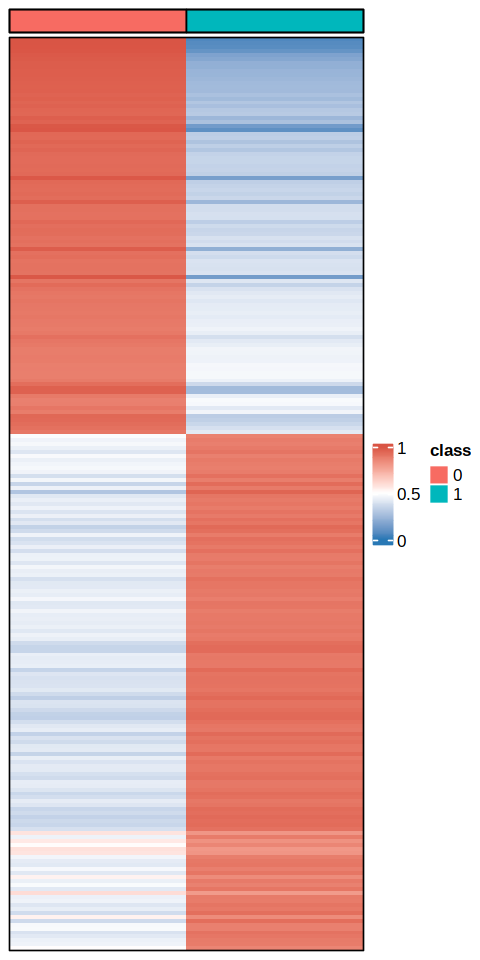

In [90]:
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = F))
options(repr.plot.width = 4 ,repr.plot.height = 8)
marker_heatmap<- Heatmap(marker_exp,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = F,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
         col = col_fun,
        border = 'black',
#         rect_gp = gpar(col = "black", lwd = 0),
        row_names_gp = gpar(fontsize = 10),
        column_names_gp = gpar(fontsize = 10),
        top_annotation = top_anno)
marker_heatmap

# FigS2 B

In [99]:
library(Matrix)


Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand


The following objects are masked from 'package:tidyr':

    expand, pack, unpack




In [94]:
mat.tag <- function(tag,mat){
    tmp.mat <- t(as.matrix(mat))
    colnames(tmp.mat) <- paste(tag,colnames(tmp.mat),sep = '_')
    return(tmp.mat)
}
# function from URD
dsCombineDGE <- function(list.dge) {
  all.gene.names <- sort(unique(unlist(lapply(list.dge, function(x) rownames(x)))))
  # Expand each data frame to include a bunch of NAs where a gene was missing
  for (i in 1:length(list.dge)) {
    genes.not.in.this.matrix <- setdiff(all.gene.names, rownames(list.dge[[i]]))
    if (length(genes.not.in.this.matrix) > 0) {
      add.matrix <- Matrix(data=rep(0, length(genes.not.in.this.matrix) * dim(list.dge[[i]])[2]), nrow=length(genes.not.in.this.matrix),
                           sparse=T)
      rownames(add.matrix) <- genes.not.in.this.matrix
      list.dge[[i]] <- rbind(list.dge[[i]], add.matrix)
      list.dge[[i]] <- list.dge[[i]][all.gene.names,]
    }
  }
  # Now cbind all the data frames
  combined.dge <- do.call(cbind,list.dge)
  return(combined.dge)
}

In [95]:
sc_layer_read <- function(path,layer){
    setwd(path)
    file_names <- list.dirs(path,full.names = F,recursive = F)
    adata_list <- list()

    for (name in file_names) {
      adata_list[[name]] <- read_h5ad(paste0(name, "/adata.h5ad"))
    }
    mat_list <- list()

    for (name in file_names) {
      mat_list[[name]] <- mat.tag(name,adata_list[[name]]$layers[layer])
    }
    mat.all <- dsCombineDGE(mat_list)
    sc <- CreateSeuratObject(counts = mat.all,min.cells = 3,min.features = 0)
    grep("^mt-",rownames(sc@assays$RNA@counts),value=T)
    #add percent.mt
    sc[["percent.mt"]] <- PercentageFeatureSet(sc, pattern = "^mt-")
    sc@meta.data$sample <- str_split(sc@meta.data$orig.ident,'b',n=2,simplify = T)[,1]
    sc@meta.data$batch <- str_split(sc@meta.data$orig.ident,'b',n=2,simplify = T)[,2]
    sc@meta.data$barcode <- rownames(sc@meta.data)
    sc@meta.data$cell <- str_split(sc@meta.data$barcode,'_',n=2,simplify = T)[,2]
    return(sc)
}

In [96]:
sc_read <- function (path) 
{
    setwd(path)
    file_names <- list.dirs(path, full.names = F, recursive = F)
    adata_list <- list()
    for (name in file_names) {
        adata_list[[name]] <- read_h5ad(paste0(name, "/adata.h5ad"))
    }
    mat_list <- list()
    for (name in file_names) {
        mat_list[[name]] <- mat.tag(name, adata_list[[name]]$X)
    }
    mat.all <- dsCombineDGE(mat_list)
    sc <- CreateSeuratObject(counts = mat.all, min.cells = 3, 
        min.features = 0)
    grep("^mt-", rownames(sc@assays$RNA@counts), value = T)
    sc[["percent.mt"]] <- PercentageFeatureSet(sc, pattern = "^mt-")
    sc@meta.data$sample <- str_split(sc@meta.data$orig.ident,'b',n=2,simplify = T)[,1]
    sc@meta.data$batch <- str_split(sc@meta.data$orig.ident,'b',n=2,simplify = T)[,2]
    sc@meta.data$barcode <- rownames(sc@meta.data)
    sc@meta.data$cell <- str_split(sc@meta.data$barcode,'_',n=2,simplify = T)[,2]
    return(sc)
}

In [97]:
get_exp <- function(sc,x){
    exp <- GetAssayData(sc)
    exp_gene <- Matrix::rowSums(exp)
    exp_gene <- as.data.frame(exp_gene) 
    colnames(exp_gene)[1] <- x
    exp_gene$gene <- rownames(exp_gene)
    return(exp_gene)
}

In [100]:
sc.x <- sc_read('/home/mingjian/workbase/04_chemical.methods/06.all_batch_methods/02.dynast/estimate_total')
sc.xl <- sc_layer_read('/home/mingjian/workbase/04_chemical.methods/06.all_batch_methods/02.dynast/estimate_total','X_l_TC_est')
sc.xn <- sc_layer_read('/home/mingjian/workbase/04_chemical.methods/06.all_batch_methods/02.dynast/estimate_total','X_n_TC_est')

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [102]:
sample_order <- c('Ctrl','in-situ-IAA','IAA','mCPBA+TFEA-pH5.2','mCPBA+TFEA-pH7.4','NaIO4+TFEA-pH5.2','NaIO4+TFEA-pH7.4','NaIO4+NH4Cl-pH8.8')

In [103]:
label_df <- get_exp(subset(sc.xl,sample == 'Ctrl'),'Ctrl') %>% dplyr::select(1)
for (sample1 in sample_order[2:8]) {
    label_df2 <- get_exp(subset(sc.xl,sample == sample1),sample1) %>% dplyr::select(1)
    label_df <- cbind(label_df,label_df2)
}

In [104]:
label_df <- label_df %>%
    mutate(across(everything(), ~ log(.x / 10000 + 1)))

In [105]:
old_df <- get_exp(subset(sc.xn,sample == 'Ctrl'),'Ctrl') %>% dplyr::select(1)
for (sample1 in sample_order[2:8]) {
    old_df2 <- get_exp(subset(sc.xn,sample == sample1),sample1) %>% dplyr::select(1)
    old_df <- cbind(old_df,old_df2)
}
old_df <- old_df %>%
    mutate(across(everything(), ~ log(.x / 10000 + 1)))

In [106]:
#Get NTR data frame
sample1 <- "Ctrl"
label_df2 <- get_exp(subset(sc.xl,sample == sample1),sample1) %>%# dplyr::select(1)%>%
             dplyr::rename(label_value = 1)
tot_df2 <- get_exp(subset(sc.x,sample == sample1),sample1) %>% #dplyr::select(1) %>%
           dplyr::rename(tot_value = 1)
ntr_df <- merge(label_df2, tot_df2, by = "gene", all.x = TRUE) %>%
                  mutate(label_log =log(label_value/10000 +1),tot_log  = log(tot_value/10000 +1))%>% 
                  mutate(ntr = label_log/tot_log) %>% dplyr::select(gene,ntr)
rownames(ntr_df) <- ntr_df$gene
colnames(ntr_df)[2] <- sample1

for (sample1 in sample_order[2:8]) {
    label_df2 <- get_exp(subset(sc.xl,sample == sample1),sample1) %>%# dplyr::select(1)%>%
                 dplyr::rename(label_value = 1)
    tot_df2 <- get_exp(subset(sc.x,sample == sample1),sample1) %>% #dplyr::select(1) %>%
               dplyr::rename(tot_value = 1)
    ntr_df2 <- merge(label_df2, tot_df2, by = "gene", all.x = TRUE) %>%
                      mutate(label_log =log(label_value/10000 +1),tot_log  = log(tot_value/10000 +1))%>% 
                      mutate(ntr = label_log/tot_log) %>% dplyr::select(gene,ntr)
    rownames(ntr_df2) <- ntr_df2$gene
    colnames(ntr_df2)[2] <- sample1
    ntr_df <- merge(ntr_df, ntr_df2, by = "gene", all.x = TRUE)
}

In [107]:
rownames(ntr_df) <- ntr_df$gene
ntr_df <- ntr_df[,-1]
ntr_df[is.na(ntr_df)] <- 0

In [108]:
head(ntr_df)

,Ctrl,in-situ-IAA,IAA,mCPBA+TFEA-pH5.2,mCPBA+TFEA-pH7.4,NaIO4+TFEA-pH5.2,NaIO4+TFEA-pH7.4,NaIO4+NH4Cl-pH8.8
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a1cf,0.00000000,0.0000000,0.2500375,0.2000400,0.5001249,0.1000450,0.0000000,0.3333667
a2ml,0.00000000,0.0000000,0.1250437,0.4445555,0.1000450,0.4001799,0.0000000,0.0000000
aaas,0.05505143,0.1781062,0.4320830,0.4273192,0.4401823,0.4032799,0.4463201,0.3941716
aacs,0.06015031,0.4762559,0.8029962,0.8339586,0.8360939,0.8791592,0.7086824,0.6886162
aadac,0.00000000,0.0000000,0.4785475,0.3186583,0.5003495,0.4549539,0.2500375,0.0000000
aadacl4,0.16670833,0.0000000,1.0000000,0.1667083,1.0000000,0.3333667,0.0000000,0.0000000


In [109]:
head(label_df)

,Ctrl,in-situ-IAA,IAA,mCPBA+TFEA-pH5.2,mCPBA+TFEA-pH7.4,NaIO4+TFEA-pH5.2,NaIO4+TFEA-pH7.4,NaIO4+NH4Cl-pH8.8
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a1cf,0.000000000,0.0000000000,0.000099995,0.000099995,0.000499875,0.0000999950,0.000000000,0.000099995
a2ml,0.000000000,0.0000000000,0.000099995,0.000399920,0.000099995,0.0005998201,0.000000000,0.000000000
aaas,0.001808678,0.0007996802,0.023052135,0.023728742,0.029494075,0.0239549639,0.006776984,0.006993267
aacs,0.003294567,0.0026122303,0.050116004,0.073626508,0.062719338,0.0698561629,0.011039876,0.013028540
aadac,0.000000000,0.0000000000,0.001099395,0.001399021,0.001399021,0.0014988761,0.000099995,0.000000000
aadacl4,0.000099995,0.0000000000,0.000299955,0.000099995,0.000099995,0.0000999950,0.000000000,0.000000000


In [110]:
panel.fill<- function(x, y, digits = 2, prefix = "",col = "", cex.cor, ...){
    par(usr = c(0, 1, 0, 1)) 
     r <- abs(cor(x, y))
     txt <- format(r, digits = digits)[1]
     col <- colorRampPalette(c('white','grey','#A6CCE7','#3984C3','#0658A5'))(100)
     rect(0, 0, 1, 1, col = col[ceiling(r * 100)])
     text(0.5, 0.5, txt, cex = 1.5,col = 'white', font = 2 )
}

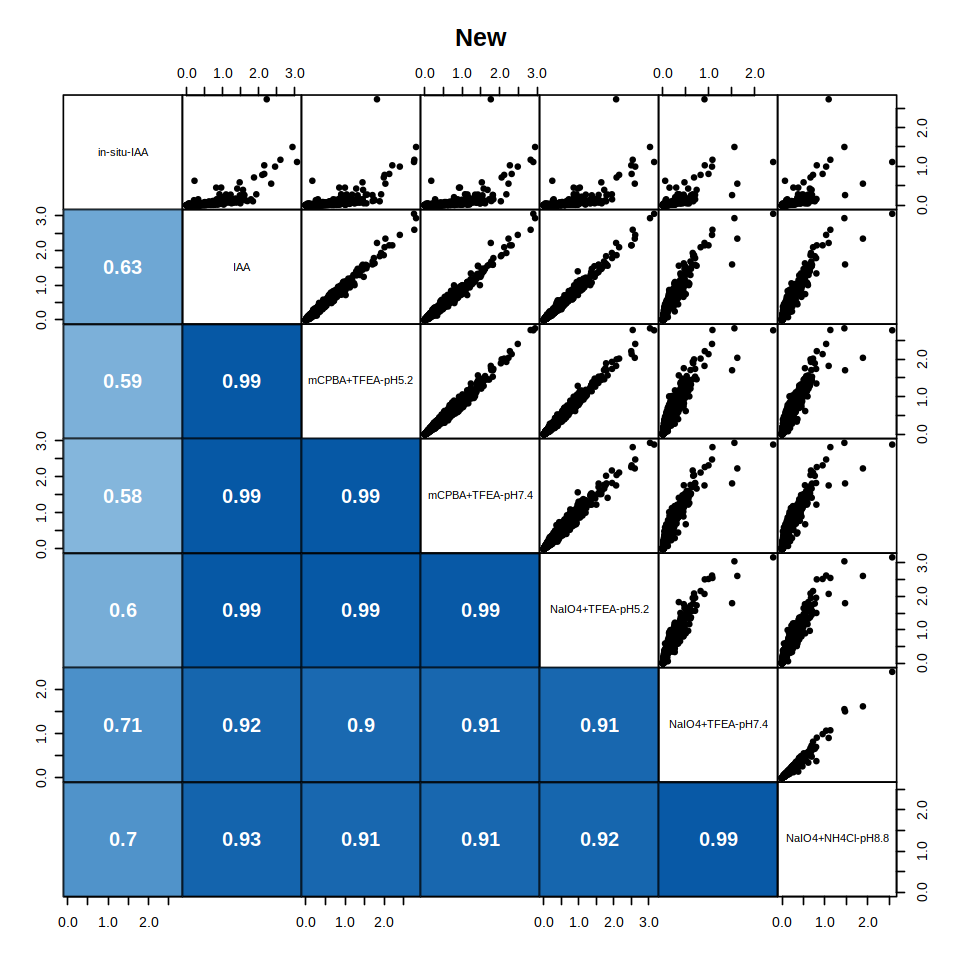

In [112]:
options(repr.plot.height =8, repr.plot.width = 8)
pairs(label_df[,-1],lower.panel = panel.fill,gap = 0,pch=20,main = "New")

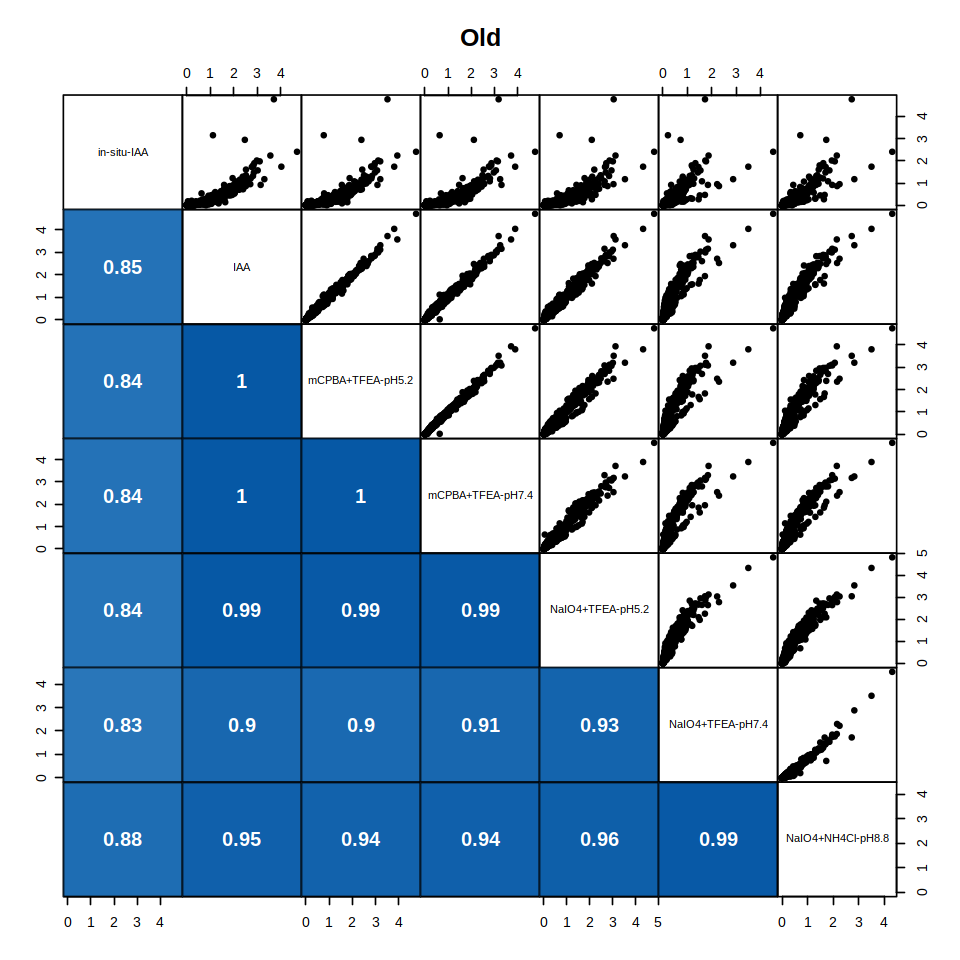

In [113]:
pairs(old_df[,-1], lower.panel = panel.fill, gap = 0,pch=20,main = "Old")

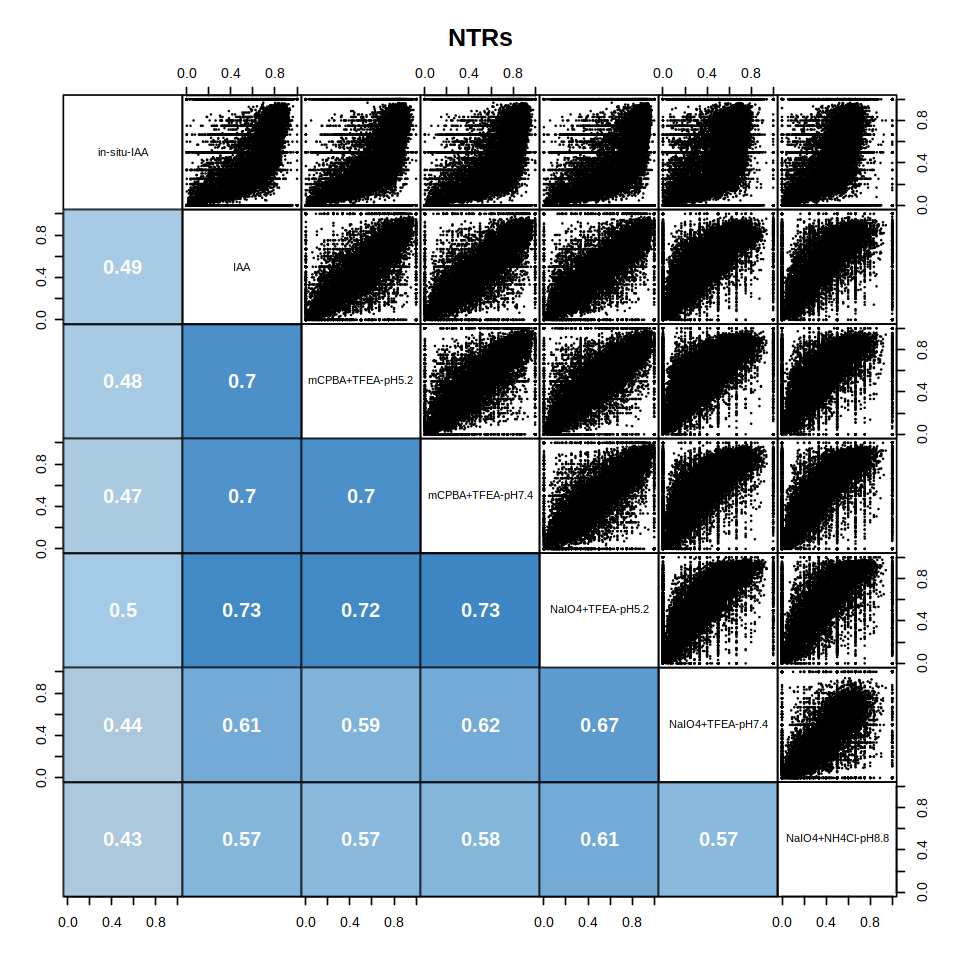

In [ ]:
pairs(ntr_df[,-1], lower.panel = panel.fill, gap = 0,pch = 20, cex = .001,main = "NTRs")